In [3]:
import os
import shutil
import numpy as np
from sklearn.model_selection import train_test_split

images_path = r"C:\Users\aashutosh kumar\Music\Training\frames"
masks_path = r"C:\Users\aashutosh kumar\Music\Training\lane-masks"

dataset_path = "Dataset"
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")
test_path = os.path.join(dataset_path, "test")

for path in [train_path, val_path, test_path]:
    os.makedirs(os.path.join(path, "images"), exist_ok=True)
    os.makedirs(os.path.join(path, "masks"), exist_ok=True)

image_files = sorted(os.listdir(images_path))
mask_files = sorted(os.listdir(masks_path))

assert len(image_files) == len(mask_files), "Mismatch between images and masks."

train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_files, mask_files, test_size=0.3, random_state=42
)
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

def move_files(files, src_folder, dest_folder):
    for file in files:
        shutil.copy(os.path.join(src_folder, file), os.path.join(dest_folder, file))

move_files(train_images, images_path, os.path.join(train_path, "images"))
move_files(train_masks, masks_path, os.path.join(train_path, "masks"))

move_files(val_images, images_path, os.path.join(val_path, "images"))
move_files(val_masks, masks_path, os.path.join(val_path, "masks"))

move_files(test_images, images_path, os.path.join(test_path, "images"))
move_files(test_masks, masks_path, os.path.join(test_path, "masks"))

print("Dataset organized successfully!")


Dataset organized successfully!


In [6]:
import tensorflow as tf

def load_data(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, (256, 256)) / 255.0  # Normalize
    
    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (256, 256))
    mask = tf.cast(mask > 127, tf.float32)  # Binarize (values 0 or 1)
    
    return image, mask

def data_pipeline(image_paths, mask_paths, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [5]:
from tensorflow.keras import layers, Model

def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    
    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [7]:
import os

def get_file_paths(directory):
    """
    Returns a sorted list of file paths in the given directory.
    Assumes that images and masks are named correspondingly.
    """
    return sorted([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith(('.jpg', '.png', '.jpeg'))])

# Collect file paths
train_image_paths = get_file_paths(r"D:\Research\Dataset\train\images")
train_mask_paths = get_file_paths(r"D:\Research\Dataset\train\masks")
val_image_paths = get_file_paths(r"D:\Research\Dataset\val\images")
val_mask_paths = get_file_paths(r"D:\Research\Dataset\val\masks")

# Debugging: Verify file paths
print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of training masks: {len(train_mask_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of validation masks: {len(val_mask_paths)}")


Number of training images: 2538
Number of training masks: 2538
Number of validation images: 544
Number of validation masks: 544


In [8]:
train_dataset = data_pipeline(train_image_paths, train_mask_paths, batch_size=16)
val_dataset = data_pipeline(val_image_paths, val_mask_paths, batch_size=16)

In [9]:
for images, masks in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Mask batch shape:", masks.shape)


Image batch shape: (16, 256, 256, 3)
Mask batch shape: (16, 256, 256, 1)


In [14]:
h = model.fit(train_dataset, validation_data=val_dataset, epochs=25)

Epoch 1/25


ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_6/Relu' defined at (most recent call last):
    File "c:\a\envs\env\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\a\envs\env\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\a\envs\env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\a\envs\env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\a\envs\env\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\a\envs\env\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\a\envs\env\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\a\envs\env\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\a\envs\env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\a\envs\env\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\a\envs\env\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\a\envs\env\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\a\envs\env\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\a\envs\env\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\a\envs\env\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\a\envs\env\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\a\envs\env\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\a\envs\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\a\envs\env\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\a\envs\env\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\a\envs\env\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\aashutosh kumar\AppData\Local\Temp\ipykernel_23592\4184604206.py", line 1, in <module>
      h = model.fit(train_dataset, validation_data=val_dataset, epochs=25)
    File "c:\a\envs\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\a\envs\env\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\a\envs\env\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\a\envs\env\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\a\envs\env\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\a\envs\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\a\envs\env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\a\envs\env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\a\envs\env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\a\envs\env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_6/Relu'
OOM when allocating tensor with shape[16,256,128,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_6/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1997]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


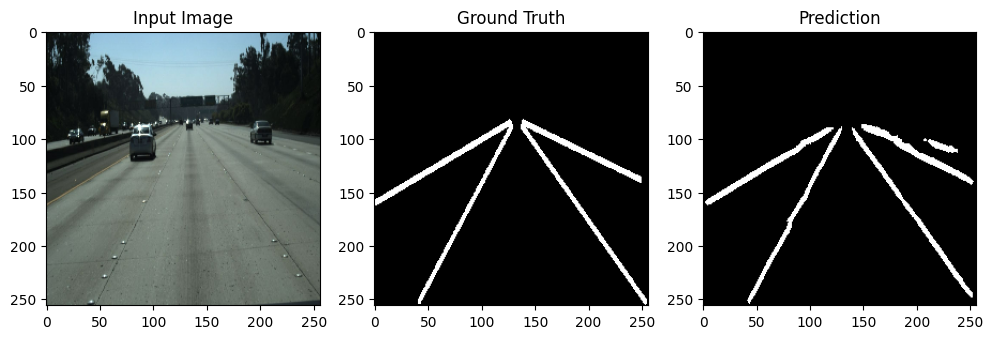

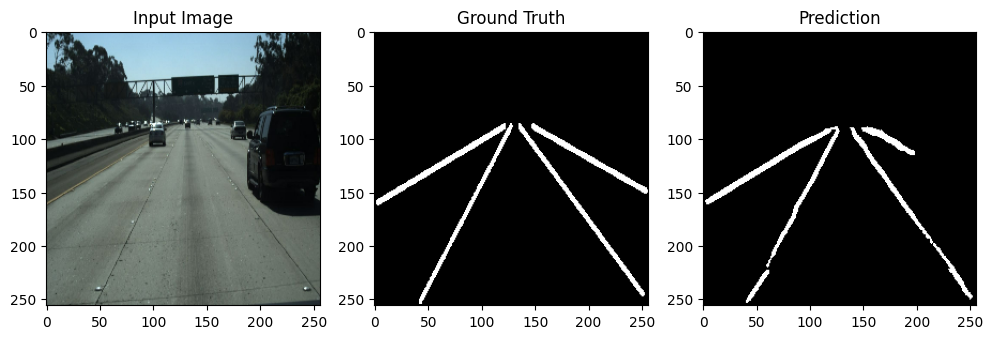

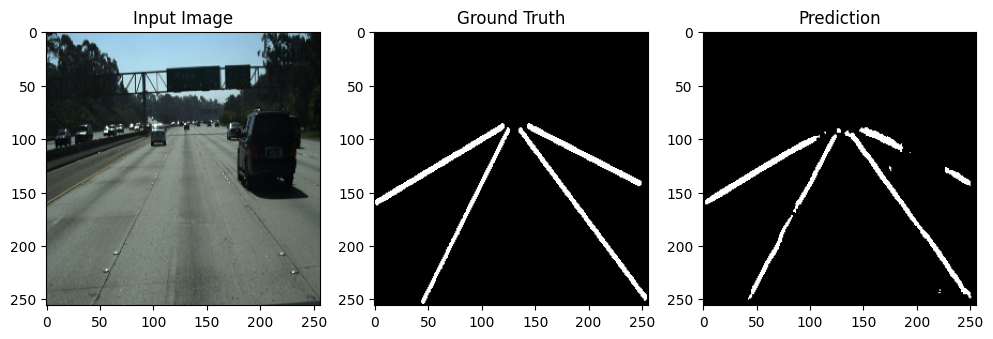

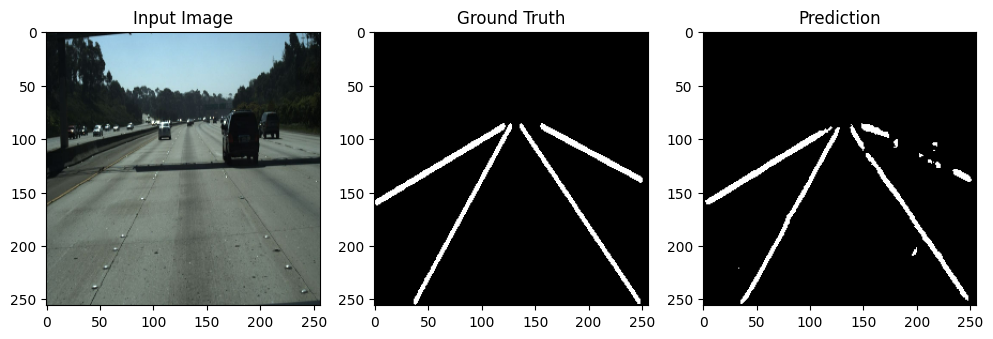

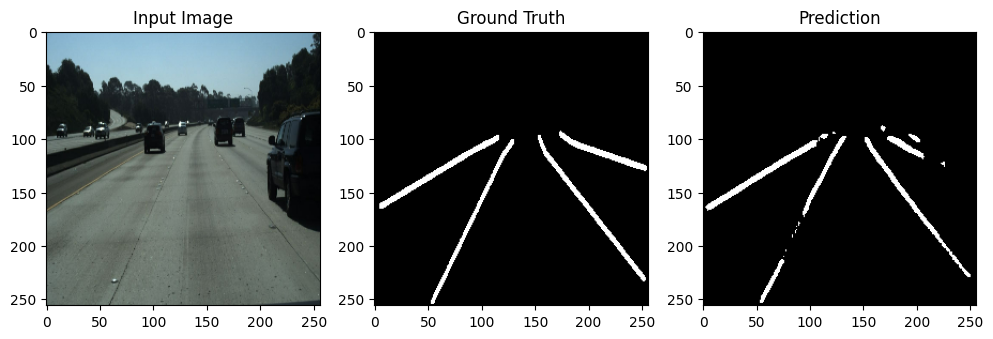

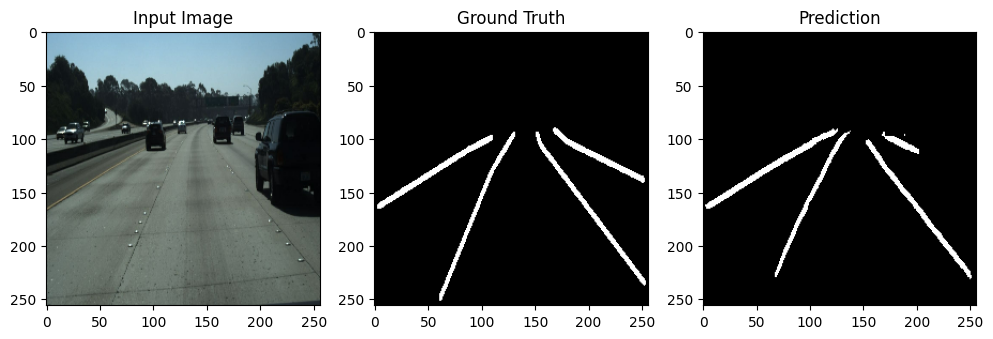

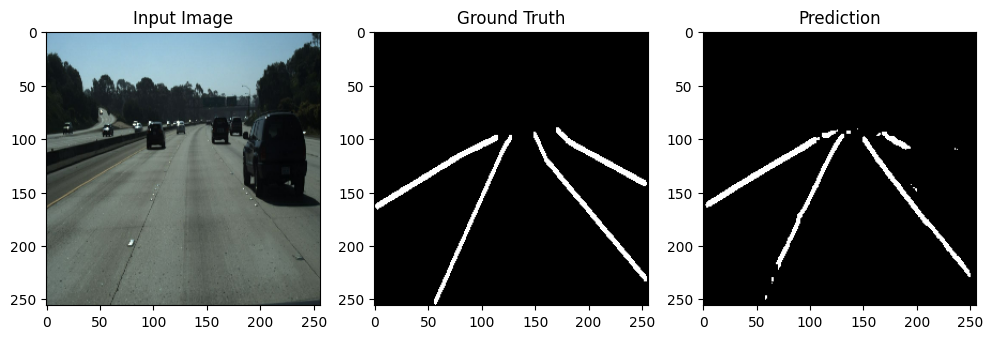

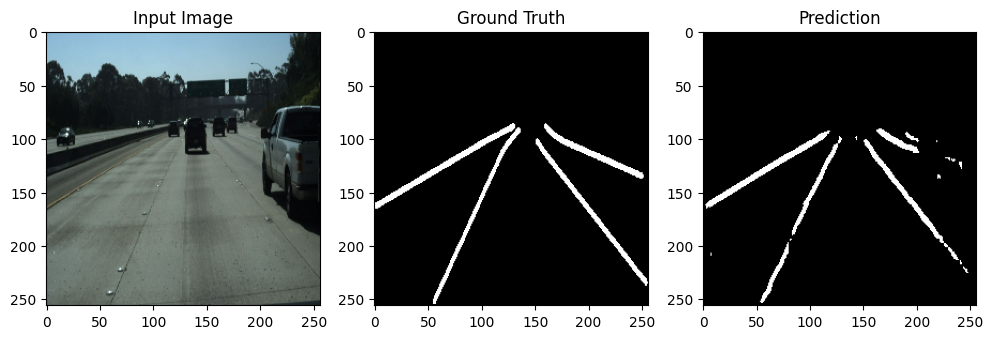

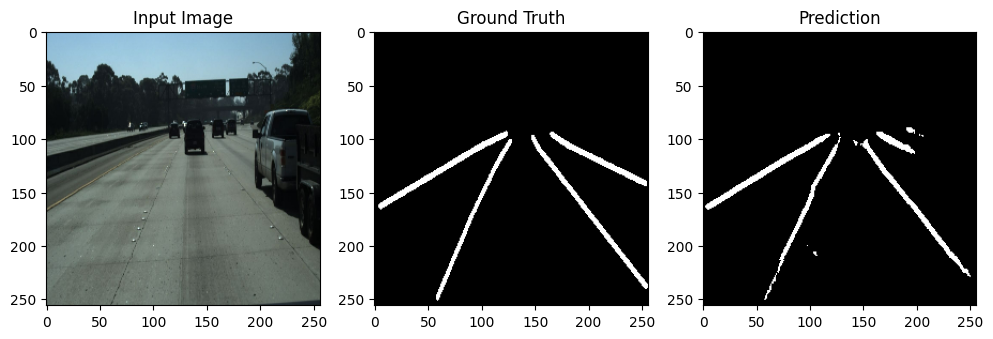

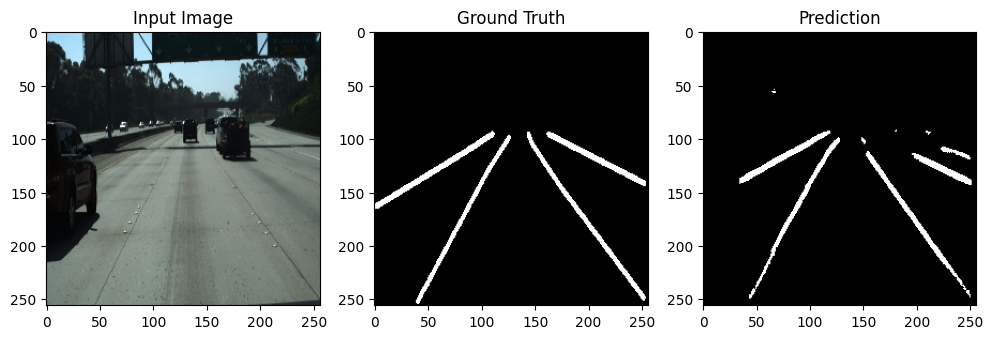

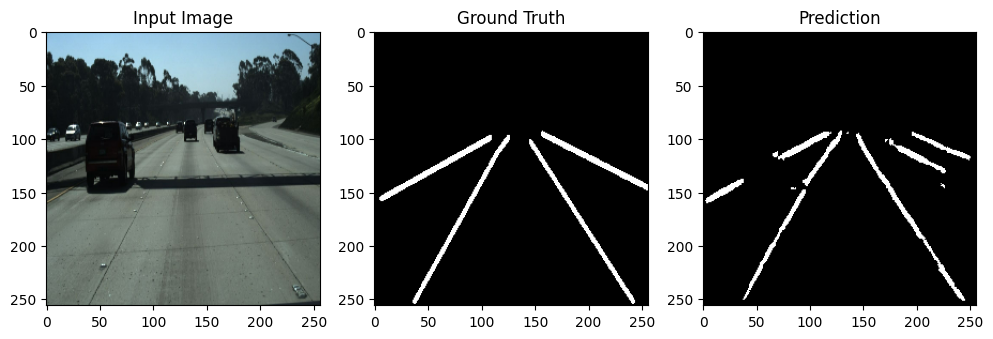

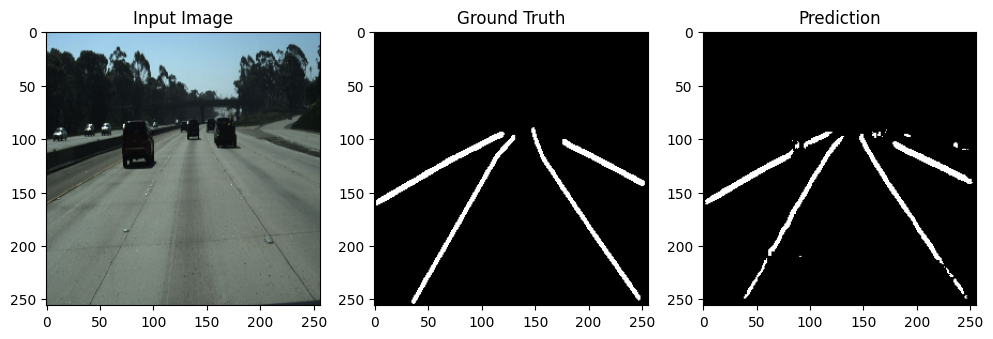

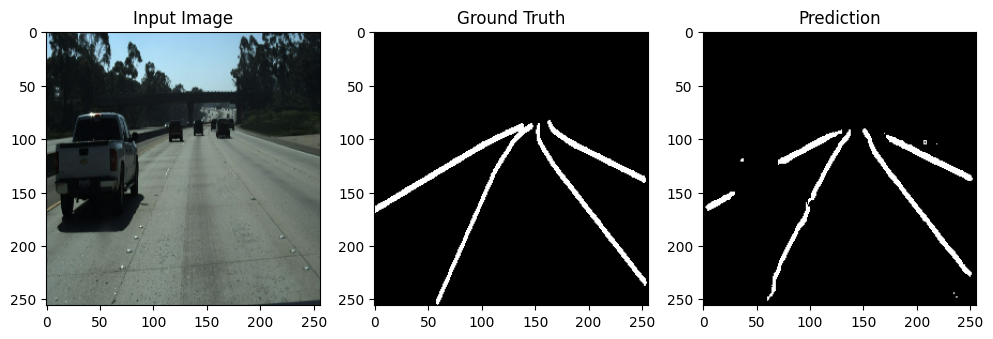

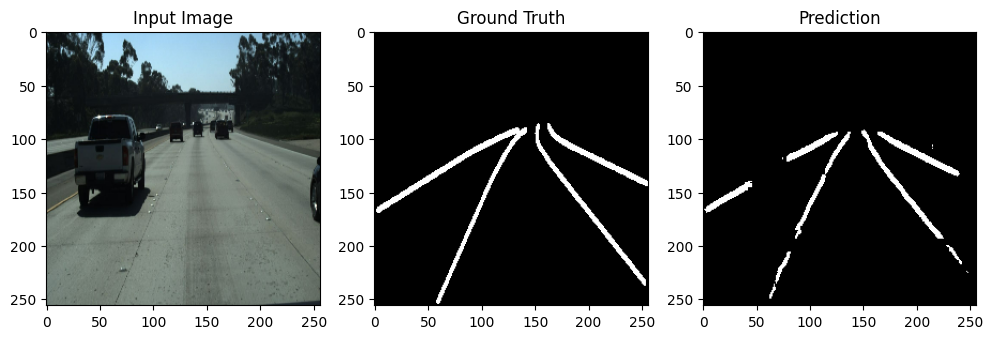

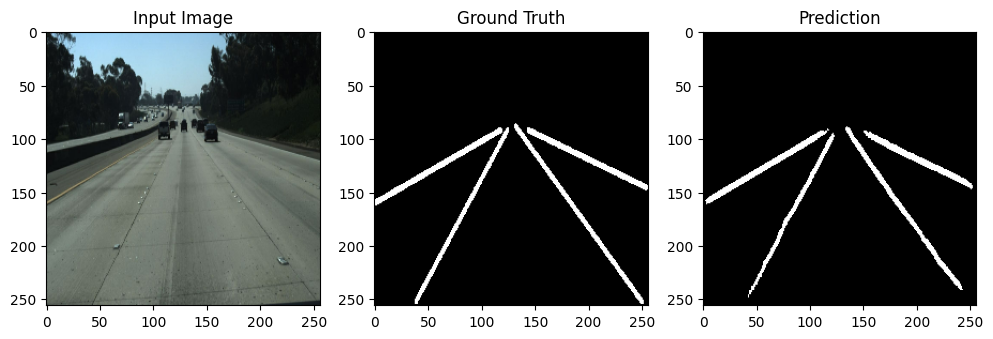

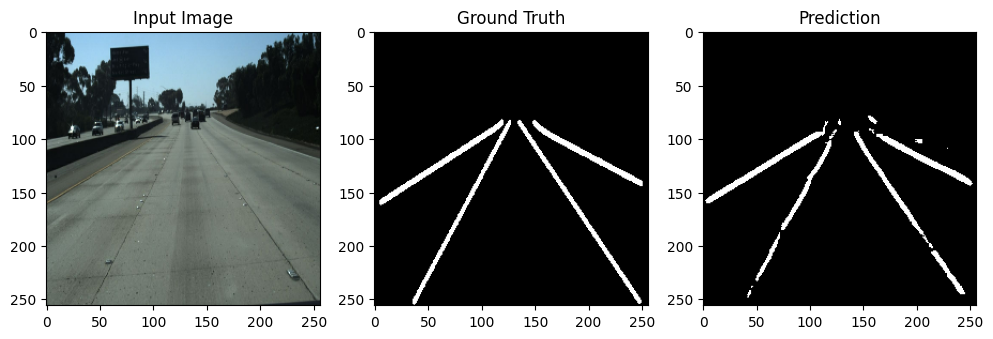

In [11]:
import matplotlib.pyplot as plt

def visualize_predictions(model, test_dataset):
    for images, masks in test_dataset.take(1):  # Take one batch
        preds = model.predict(images)
        preds = (preds > 0.5).astype("uint8")
        
        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i])
            
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
            
            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(preds[i].squeeze(), cmap="gray")
            plt.show()

visualize_predictions(model, val_dataset)

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def process_frame(frame, model):
    """
    Process a single video frame through the trained model.

    Parameters:
    - frame: The input frame from the video (BGR format).
    - model: The trained lane detection model.

    Returns:
    - result_frame: The frame with lane predictions overlayed.
    """
    # Resize frame to match the model input size
    input_size = (256, 256)  # Adjust this based on your model's input size
    resized_frame = cv2.resize(frame, input_size)

    # Normalize the frame (same preprocessing as during training)
    normalized_frame = resized_frame / 255.0

    # Expand dimensions to create a batch of one
    input_batch = np.expand_dims(normalized_frame, axis=0)

    # Predict the lane mask
    predicted_mask = model.predict(input_batch)[0]

    # Threshold and resize mask back to original frame size
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    predicted_mask = cv2.resize(predicted_mask, (frame.shape[1], frame.shape[0]))

    # Create an overlay
    overlay = frame.copy()
    overlay[predicted_mask == 1] = [0, 255, 0]  # Green lanes

    # Blend the original frame and the overlay
    result_frame = cv2.addWeighted(frame, 0.7, overlay, 0.3, 0)

    return result_frame


In [14]:
def process_video(video_path, output_path, model):
    """
    Process a video for lane detection using the trained model.

    Parameters:
    - video_path: Path to the input video.
    - output_path: Path to save the processed video.
    - model: The trained lane detection model.
    """
    # Open the video
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Define the video writer
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Codec
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Process each frame
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame
        result_frame = process_frame(frame, model)

        # Write the processed frame to the output video
        out.write(result_frame)

        # Display the result (optional, for visualization)
        cv2.imshow("Lane Detection", result_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):  # Press 'q' to quit
            break

    # Release resources
    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processed video saved at: {output_path}")


In [2]:
from tensorflow.keras.models import load_model
model_path = r"C:\Users\aashutosh kumar\Downloads\LD.h5"  
model = load_model(model_path)

In [15]:
video_path = r"C:\Projects\Lane_Detection\80400-572395752_tiny.mp4"  # Input video file
output_path = r"D:\Research\output_video.avi"  # Output video file

process_video(video_path, output_path, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy", MeanIoU(num_classes=2)])


In [ ]:
results = model.evaluate(val_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Pixel Accuracy: {results[1]:.4f}")
print(f"Mean IoU: {results[2]:.4f}")  

34/34 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9731 - loss: 0.0741 - mean_io_u: 0.4783
Loss: 0.0724
Pixel Accuracy: 0.9737
Mean IoU: 0.4785


In [20]:
val_image_paths = get_file_paths(r"D:\Research\Dataset\test\images")
val_mask_paths = get_file_paths(r"D:\Research\Dataset\test\masks")

In [21]:
test_dataset = data_pipeline(val_image_paths, val_mask_paths, batch_size=16)

In [22]:
results = model.evaluate(test_dataset)
print(f"Loss: {results[0]:.4f}")
print(f"Pixel Accuracy: {results[1]:.4f}")
print(f"Mean IoU: {results[2]:.4f}") 

34/34 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.9741 - loss: 0.0724 - mean_io_u: 0.4786
Loss: 0.0713
Pixel Accuracy: 0.9741
Mean IoU: 0.4787


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


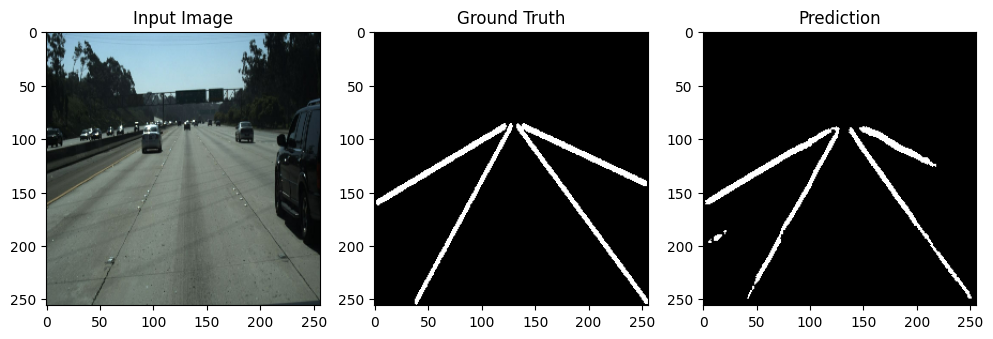

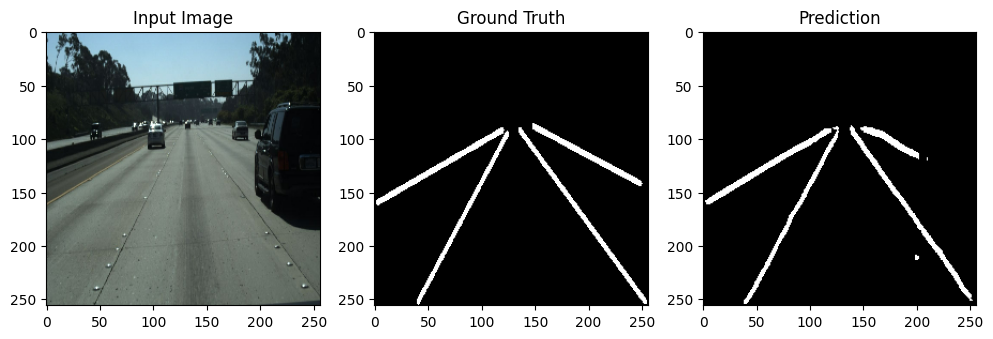

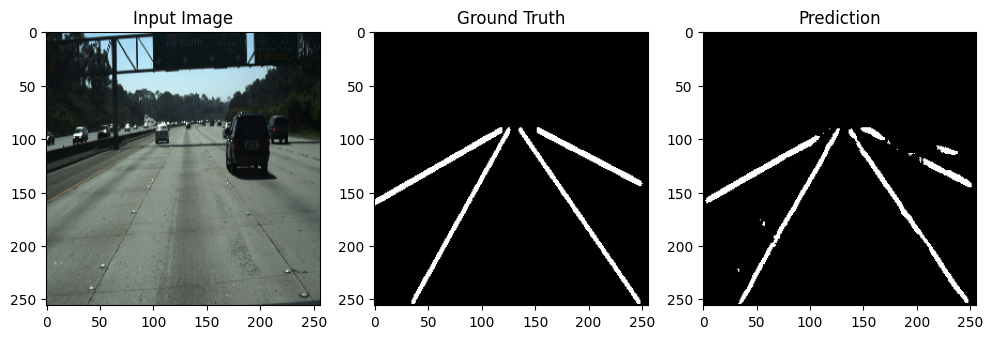

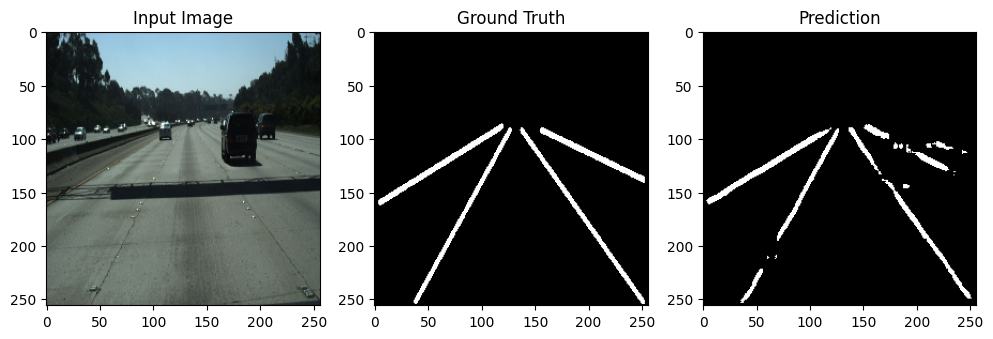

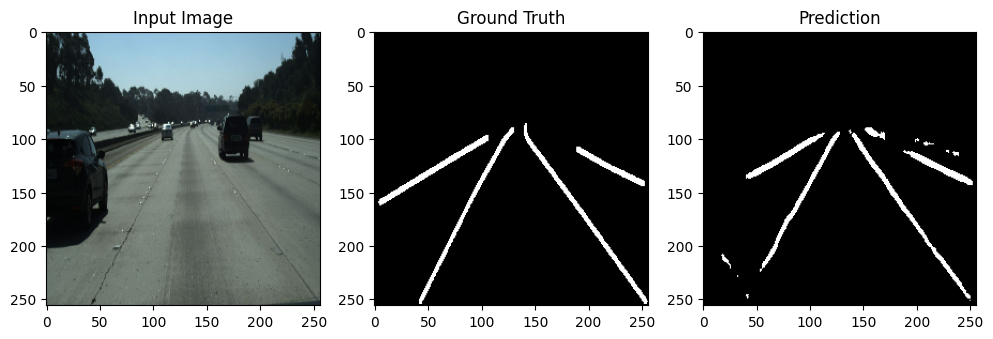

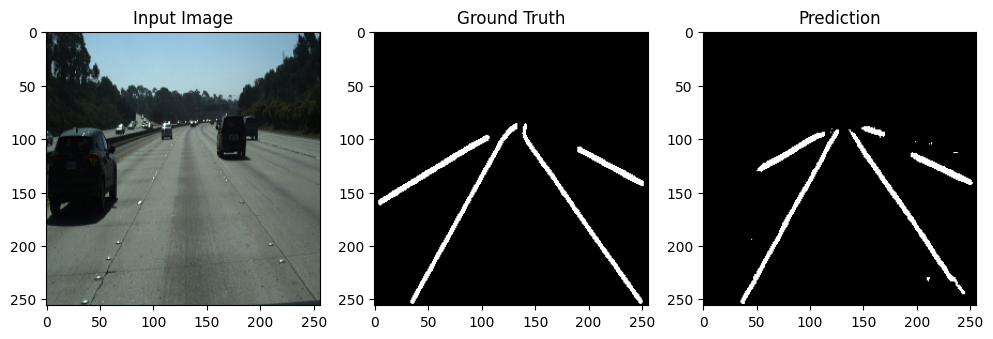

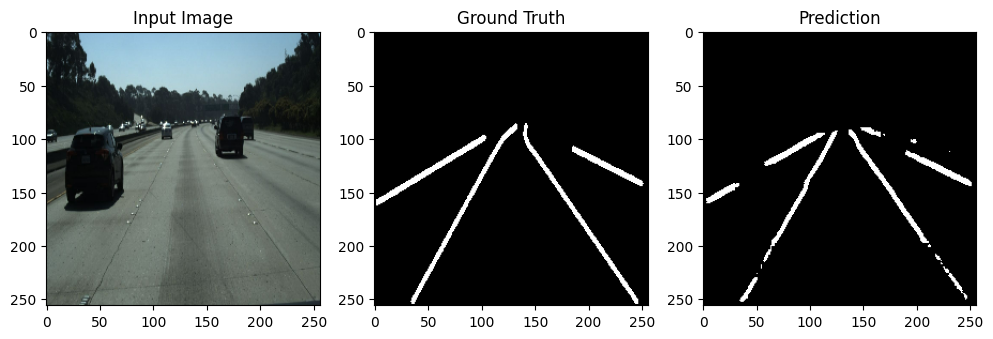

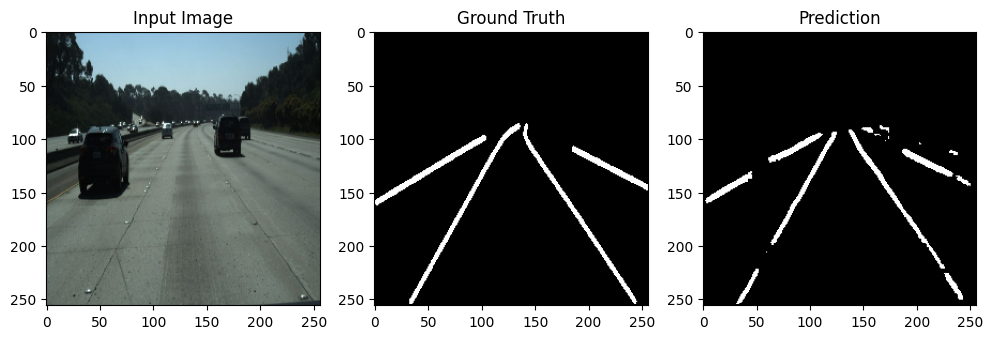

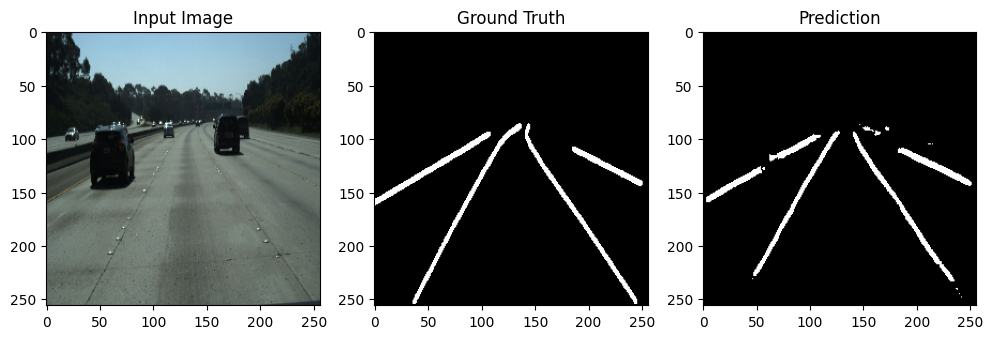

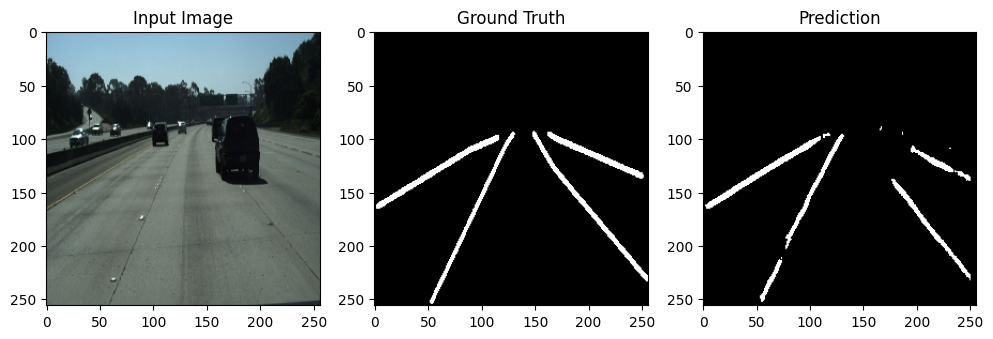

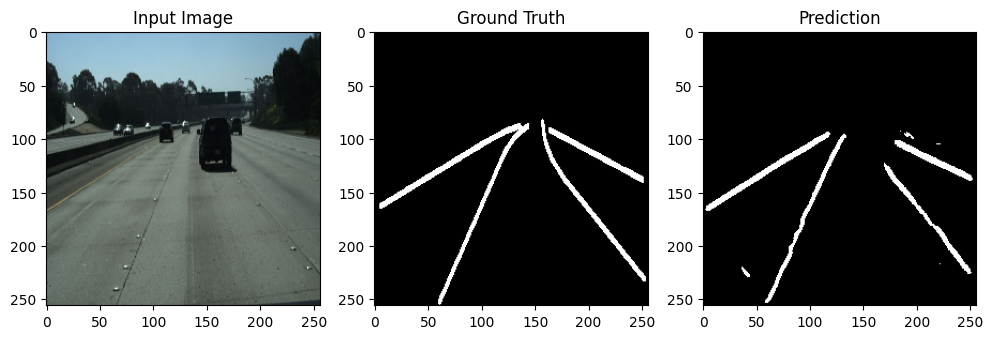

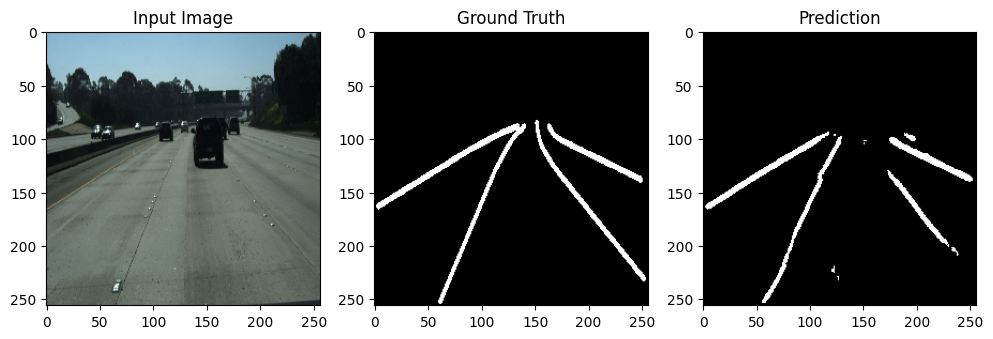

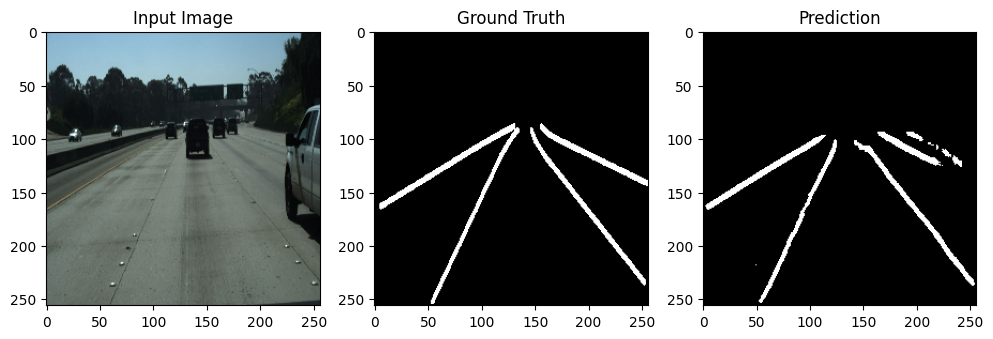

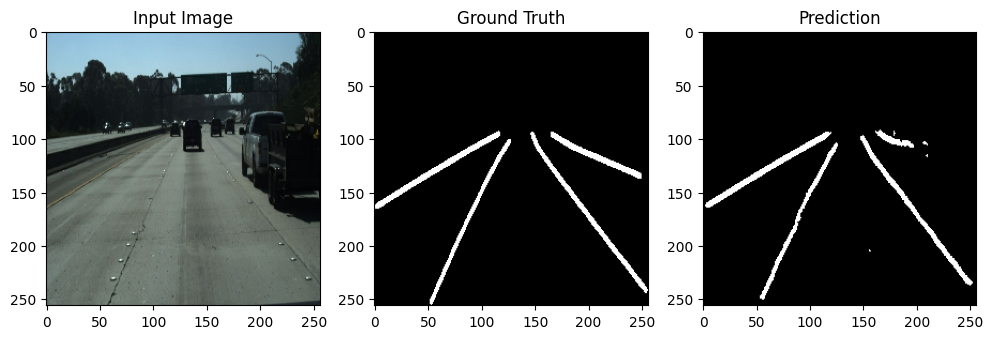

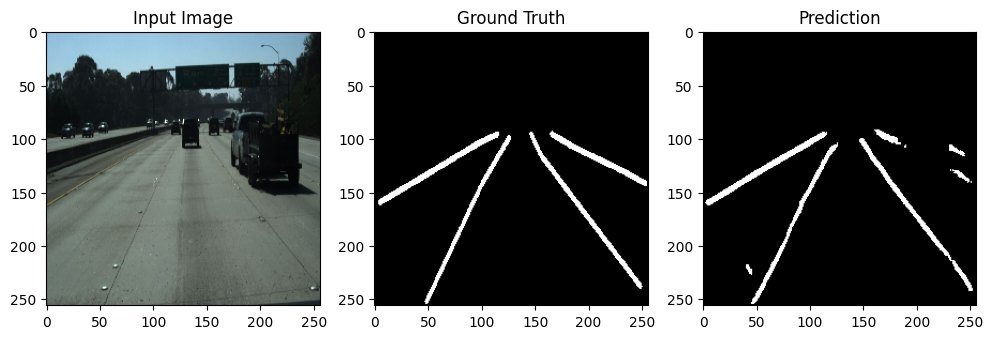

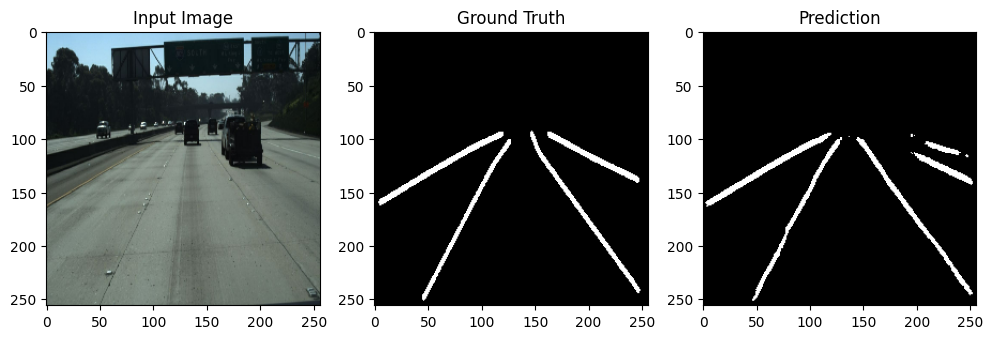

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_unet_predictions(model, dataset):
    for images, masks in dataset.take(1):  # Take one batch from the dataset
        preds = model.predict(images)      # Predict on the batch
        preds = (preds > 0.5).astype("uint8")  # Binarize predictions
        
        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i])
            
            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
            
            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(preds[i].squeeze(), cmap="gray")
            plt.show()
            
# Visualize predictions
visualize_unet_predictions(model, test_dataset)
